# Imports

In [79]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import time

# Load Dataset & Preprocessing

In [11]:
# Load the data
taylor_raw = pd.read_csv('TaylorSwift.csv')
drake_raw = pd.read_csv('Drake.csv')
beyonce_raw = pd.read_csv('Beyonce.csv')
rihanna_raw = pd.read_csv('Rihanna.csv')
ariana_raw = pd.read_csv('ArianaGrande.csv')
billie_raw = pd.read_csv('BillieEilish.csv')
cardi_raw = pd.read_csv('CardiB.csv')
charlie_raw = pd.read_csv('CharliePuth.csv')
coldplay_raw = pd.read_csv('ColdPlay.csv')
dua_raw = pd.read_csv('DuaLipa.csv')
ed_raw = pd.read_csv('EdSheeran.csv')
eminem_raw = pd.read_csv('Eminem.csv')
justin_raw = pd.read_csv('JustinBieber.csv')
katy_raw = pd.read_csv('KatyPerry.csv')
khalid_raw = pd.read_csv('Khalid.csv')
gaga_raw = pd.read_csv('LadyGaga.csv')
maroon_raw = pd.read_csv('Maroon5.csv')
nicki_raw = pd.read_csv('NickiMinaj.csv')
post_raw = pd.read_csv('PostMalone.csv')
selena_raw = pd.read_csv('SelenaGomez.csv')

In [12]:
def make_df(raw_list):
    # handle dropped rows
    for df in raw_list:
        df.reset_index(drop=True, inplace=True)

    data = pd.concat(raw_list, ignore_index=True)

    # fix all special characters
    data['Lyric'] = data['Lyric'].str.replace('’', "'")
    data['Lyric'] = data['Lyric'].str.replace(' ', " ")
    data['Lyric'] = data['Lyric'].fillna('')
    data['Lyric'] = data['Lyric'].str.replace("'", '')

    # handle drops
    data = data.drop(columns=['Album', 'Title', 'Album', 'Year', 'Date'])
    data = data.drop(columns='Unnamed: 0')
    data = data.dropna()

    # get the name of the artist as a string and remove it from the lyrics for that row
    data['Artist'] = data['Artist'].str.lower()
    data['Lyric'] = data.apply(lambda x: x['Lyric'].replace(x['Artist'], ''), axis=1)
    
    # shuffle up the data
    data = data.sample(frac=1).reset_index(drop=True)

    return data

In [13]:
# split every song into X segments of roughly equal size
# for example, parts=3 would split the lyrics into thirds and parts=4 would split the lyrics into fourths
def split_lyrics(data, parts=3):
    data['Lyric'] = data['Lyric'].str.split()
    data['Lyric'] = data['Lyric'].apply(lambda x: np.array_split(x, parts))
    data = data.explode('Lyric')
    data = data.dropna()
    data = data.reset_index(drop=True)
    data['Lyric'] = data['Lyric'].apply(lambda x: ' '.join(x))
    return data

# Model Architecture

In [14]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
        self.softmax = nn.Softmax(dim=1)

        # initialize the weights using Xavier initialization
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                init.xavier_uniform_(param)
        init.xavier_uniform_(self.fc.weight)
    
    def forward(self, x):
        # batch_size = x.size(0)  # Get the batch size from the input

        # initialize hidden and cell states with zeros
        h0 = torch.zeros(self.num_layers*2, self.hidden_size)
        c0 = torch.zeros(self.num_layers*2, self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # decode the hidden state of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out

# Training & Eval Methods

In [15]:
def calculate_gradient_norm(model):
    total_norm = 0
    for param in model.parameters():
        if param.grad is not None:
            param_norm = param.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [16]:
def train_model(data, num_epochs=200, num_layers=2, hidden_size=64):
    # gradient norm tracking
    gradient_norms = []

    # split the data into training and testing
    vectorizer = TfidfVectorizer()
    X_train, X_test, y_train, y_test = train_test_split(data['Lyric'], data['Artist'], test_size=0.2, random_state=42)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # define hyperparameters
    input_size = X_train_vectorized.shape[1]  # number of features after vectorization
    num_classes = len(label_encoder.classes_)  # number of unique classes

    # create an instance of the model
    model = BiLSTM(input_size, hidden_size, num_layers, num_classes)

    # define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # convert data to tensors
    X_train_tensor = torch.tensor(X_train_vectorized.toarray(), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_vectorized.toarray(), dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)


    # training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train_tensor)

        # compute loss
        loss = criterion(outputs, y_train_tensor)

        # backward pass
        loss.backward()

        # clip the gradients
        # model.clip_gradient()

        gradient_norm = calculate_gradient_norm(model)
        gradient_norms.append(gradient_norm)

        # optimization step
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    # evaluation on test data
    with torch.no_grad():
        model.eval()
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == y_test_tensor).sum().item()
        total = y_test_tensor.size(0)
        accuracy = correct / total
        print(f'Test Accuracy: {accuracy:.4f}')

    plt.plot(gradient_norms)
    plt.xlabel('Epoch')
    plt.ylabel('Gradient Norm')
    plt.title('Gradient Norm Monitoring')
    plt.show()

    return model, vectorizer, label_encoder

In [26]:
def demo(model, lyrics, artist, vectorizer, label_encoder):

    lyrics_vectorized = vectorizer.transform([lyrics])
    lyrics_tensor = torch.tensor(lyrics_vectorized.toarray(), dtype=torch.float32)
    with torch.no_grad():
        model.eval()
        outputs = model(lyrics_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_artist = label_encoder.inverse_transform(predicted.numpy())[0]
        # print the beginning of the lyrics
        print(lyrics[:500])
        print(f'The model predicts that the song is by {predicted_artist}')
        print(f'The actual artist is {artist}')

        # print the top 5 predicted artists
        proba = model.softmax(outputs)
        proba, indices = torch.topk(proba, 5)
        proba = proba.numpy().flatten()
        indices = indices.numpy().flatten()
        top_artists = label_encoder.inverse_transform(indices)
        for i, singer in enumerate(top_artists):
            print(f'{singer}: {proba[i]:.4f}')

        # print " ARTISTS DON'T MATCH" if the model's prediction is incorrect
        if predicted_artist != artist:
            print("ARTISTS DON'T MATCH")
        else:
            print("ARTISTS MATCH")

        # plot the top 5 predicted artists
        plt.bar(top_artists, proba)
        plt.xlabel('Artist')
        plt.ylabel('Probability')
        plt.title('Top Predicted Artists')
        plt.xticks(rotation=45)
        plt.show()

(5749, 2)
Epoch [10/500], Loss: 2.9854
Epoch [20/500], Loss: 2.9699
Epoch [30/500], Loss: 2.9648
Epoch [40/500], Loss: 2.9498
Epoch [50/500], Loss: 2.9192
Epoch [60/500], Loss: 2.8792
Epoch [70/500], Loss: 2.8508
Epoch [80/500], Loss: 2.8261
Epoch [90/500], Loss: 2.7945
Epoch [100/500], Loss: 2.7617
Epoch [110/500], Loss: 2.7319
Epoch [120/500], Loss: 2.7121
Epoch [130/500], Loss: 2.7016
Epoch [140/500], Loss: 2.6922
Epoch [150/500], Loss: 2.6714
Epoch [160/500], Loss: 2.6502
Epoch [170/500], Loss: 2.6368
Epoch [180/500], Loss: 2.6287
Epoch [190/500], Loss: 2.6241
Epoch [200/500], Loss: 2.6213
Epoch [210/500], Loss: 2.6173
Epoch [220/500], Loss: 2.5959
Epoch [230/500], Loss: 2.5759
Epoch [240/500], Loss: 2.5647
Epoch [250/500], Loss: 2.5509
Epoch [260/500], Loss: 2.5274
Epoch [270/500], Loss: 2.4965
Epoch [280/500], Loss: 2.4532
Epoch [290/500], Loss: 2.4253
Epoch [300/500], Loss: 2.4103
Epoch [310/500], Loss: 2.4015
Epoch [320/500], Loss: 2.3962
Epoch [330/500], Loss: 2.3929
Epoch [34

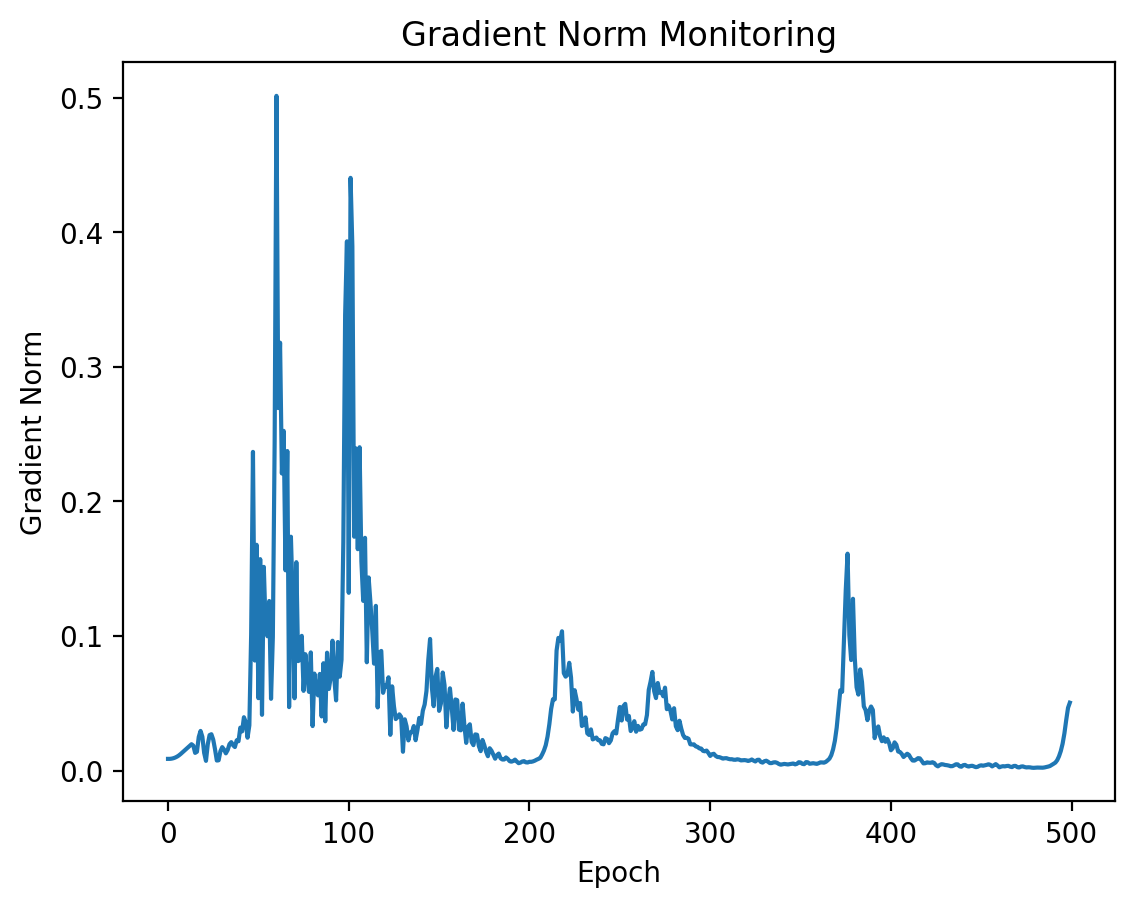

In [21]:
data = make_df([taylor_raw, drake_raw, beyonce_raw, rihanna_raw, ariana_raw, billie_raw, cardi_raw, charlie_raw, coldplay_raw, dua_raw, ed_raw, eminem_raw, justin_raw, katy_raw, khalid_raw, gaga_raw, maroon_raw, nicki_raw, post_raw, selena_raw])
data = split_lyrics(data, parts=2)
print(data.shape)

model, vectorizer, label_encoder = train_model(data, num_epochs=500, hidden_size=64, num_layers=2)

i was supposed to be sent away but they forgot to come and get me i was a functioning alcoholic 'til nobody noticed my new aesthetic all of this to say i hope you're okay but you're the reason and no one here's to blame but what about your quiet treason? and for a fortnight there, we were forever run into you sometimes, ask about the weather now you're in my backyard, turned into good neighbors your wife waters flowers, i wanna kill her all my mornings are mondays stuck in an endless february i 
The model predicts that the song is by coldplay
The actual artist is taylor swift
coldplay: 0.0536
justin bieber: 0.0524
ed sheeran: 0.0519
ariana grande: 0.0517
eminem: 0.0514
ARTISTS DON'T MATCH


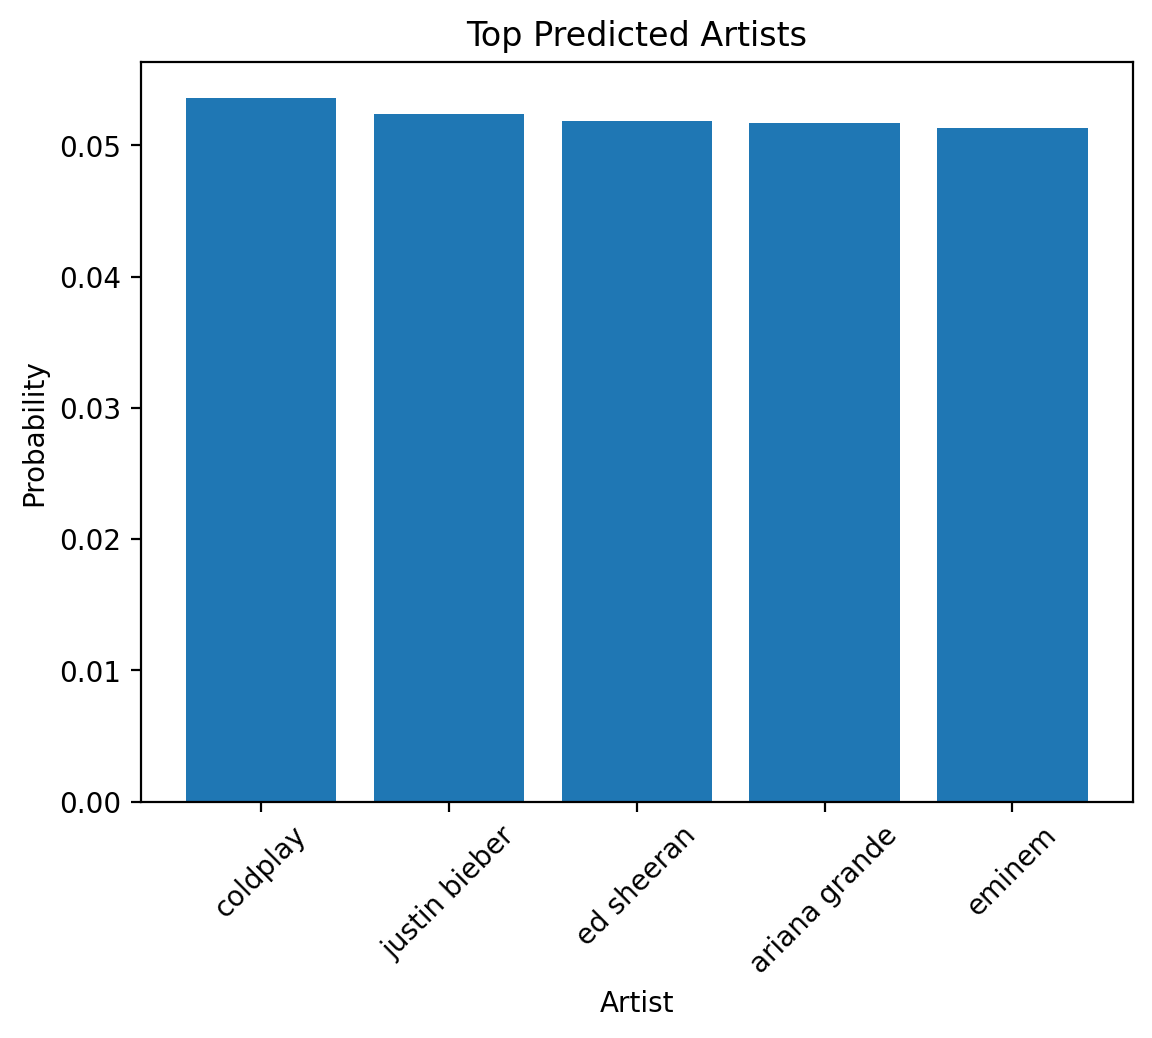

In [31]:
# brand new song for fun
new_taylor_lyrics = "I was supposed to be sent away But they forgot to come and get me I was a functioning alcoholic 'Til nobody noticed my new aesthetic All of this to say I hope you're okay But you're the reason And no one here's to blame But what about your quiet treason? And for a fortnight there, we were forever Run into you sometimes, ask about the weather Now you're in my backyard, turned into good neighbors Your wife waters flowers, I wanna kill her All my mornings are Mondays stuck in an endless February I took the miracle move-on drug, the effects were temporary And I love you, it's ruining my life I love you, it's ruining my life I touched you for only a fortnight I touched you, but I touched you And for a fortnight there, we were forever Run into you sometimes, ask about the weather Now you're in my backyard, turned into good neighbors Your wife waters flowers, I wanna kill her And for a fortnight there, we were together Run into you sometimes, comment on my sweater Now you're at the mailbox, turned into good neighbors My husband is cheating, I wanna kill him I love you, it's ruining my life I love you, it's ruining my life I touched you for only a fortnight I touched you, I touched you I love you, it's ruining my life I love you, it's ruining my life I touched you for only a fortnight I touched you, I touched you Thought of callin' ya, but you won't pick up 'Nother fortnight lost in America Move to Florida, buy the car you want But it won't start up 'til you touch, touch, touch me Thought of calling ya, but you won't pick up 'Nother fortnight lost in America Move to Florida, buy the car you want But it won't start up 'til I touch, touch, touch you"

# make lower case and get rid of any names (including featured artists this time)
new_taylor_lyrics = new_taylor_lyrics.lower()
new_taylor_lyrics = new_taylor_lyrics.replace('taylor swift', '')
new_taylor_lyrics = new_taylor_lyrics.replace('post malone', '')

demo(model, new_taylor_lyrics, 'taylor swift', vectorizer, label_encoder)

hey yo what do you think about two grown ass men living together alright what do you think about another grown ass man living right upstairs from them well those two grown ass men living together on my nuts and that shits right above them  when i rhyme somehow i think i must subliminally throwing viagra at these fags who got these hardons for me but i suppose anything goes when it comes to my flows nothing is off limits except for michaels nose i didnt know im so sorry please tell me what i can 
The model predicts that the song is by eminem
The actual artist is eminem
eminem: 0.1146
coldplay: 0.0478
nicki minaj: 0.0474
ed sheeran: 0.0469
katy perry: 0.0469
ARTISTS MATCH


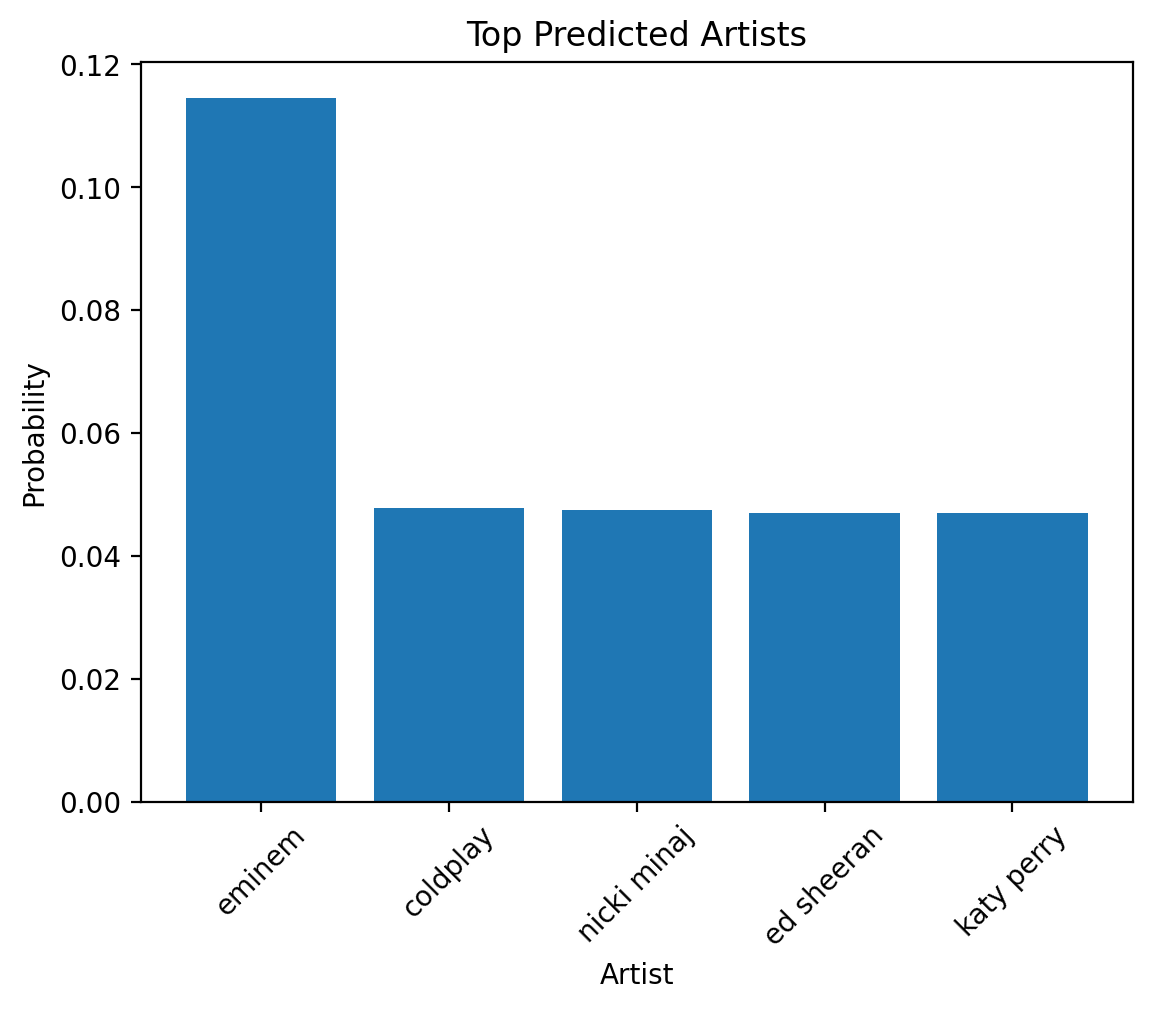

In [78]:
# pick out the lyrics of one random song from test set
# get a random lyric from the data using a rand index
X_train, X_test, y_train, y_test = train_test_split(data['Lyric'], data['Artist'], test_size=0.2, random_state=42)
data_test = pd.concat([X_test, y_test], axis=1)

rand_index = np.random.randint(0, len(data_test))

lyrics = data['Lyric'].values[rand_index]
artist = data['Artist'].values[rand_index]

demo(model, lyrics, artist, vectorizer, label_encoder)